In [10]:
import tsfresh
#from tsfresh import extract_features
from sksurv.ensemble import RandomSurvivalForest
import sksurv


NvvmError: Failed to compile

<unnamed> (114, 19): parse expected comma after load's type
NVVM_ERROR_COMPILATION

In [11]:
import sys
import os
from numba.cuda.cudadrv.libs import test, get_cudalib
from numba.cuda.cudadrv.nvvm import NVVM


def run_test():
    # on windows only nvvm is available to numba
    if sys.platform.startswith('win'):
        nvvm = NVVM()
        print("NVVM version", nvvm.get_version())
        return nvvm.get_version() is not None
    if not test():
        return False
    nvvm = NVVM()
    print("NVVM version", nvvm.get_version())
    # check pkg version matches lib pulled in
    gotlib = get_cudalib('cublas')
    lookfor = os.environ['PKG_VERSION']
    return lookfor in gotlib


sys.exit(0 if run_test() else 1)

NVVM version (1, 6)


SystemExit: 0

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
# !pip install anamod
# %pip install tsfresh --user
# %pip install dfply
# %pip install scikit-survival

  Using cached tsfresh-0.19.0-py2.py3-none-any.whl (97 kB)
  Using cached stumpy-1.10.2-py3-none-any.whl (119 kB)
  Using cached matrixprofile-1.1.10-cp38-cp38-win_amd64.whl (515 kB)


ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

statsmodels 0.13.2 requires patsy>=0.5.2, but you'll have patsy 0.5.1 which is incompatible.



  Using cached statsmodels-0.13.2-cp38-cp38-win_amd64.whl (9.1 MB)
  Using cached protobuf-3.11.2-py2.py3-none-any.whl (434 kB)
  Using cached packaging-21.3-py3-none-any.whl (40 kB)


In [3]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import seed

os.getcwd()
os.chdir('/home/hugh/CARDIA_project')
sys.path.append('./DeepSurv/deepsurv')
import anamod
from anamod import TemporalModelAnalyzer


In [4]:

work_dir = '/home/idies/workspace/Storage/hnguye78/persistent/CARDIA_longi_project'
#data_file_name = 'data_longi_long_up_to_y15_prior_model_training'
data_file_name = 'data_longi_ascvd_for_dynamic_deephit'
load_dir = work_dir+ '/csv_files'

# load data:
data = pd.read_csv(load_dir+'/'+data_file_name+'.csv')
data = data.select_dtypes(include =[np.number])



In [5]:
data

,ID,event,exam_year,time,AGE_Y0,MALE,RACEBLACK,CHOL,DIAB,HBM,HDL,SBP,SMKNW
0,100033323702,0,0,32.134155,22,1,0,231,0,0,42,117.0,1
1,100033323702,0,2,32.134155,22,1,0,187,0,0,46,116.0,1
2,100033323702,0,5,32.134155,22,1,0,234,0,0,52,105.0,0
3,100033323702,0,7,32.134155,22,1,0,216,0,0,44,115.0,0
4,100033323702,0,15,32.134155,22,1,0,214,0,0,42,107.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201,416817227898,0,2,31.770021,22,1,1,203,0,0,56,102.0,1
20202,416817227898,0,5,31.770021,22,1,1,204,0,0,43,133.0,1
20203,416817227898,0,7,31.770021,22,1,1,170,0,0,47,133.0,1
20204,416817227898,0,10,31.770021,22,1,1,179,0,0,47,112.0,0


In [6]:
data_ts = data.loc[:, ~data.columns.isin(['Unnamed: 0', 'event','time','RACEBLACK','MALE','AGE_Y0'])]
# data_ts.rename(columns={"exam_year": "time"}
data_ts


,ID,exam_year,CHOL,DIAB,HBM,HDL,SBP,SMKNW
0,100033323702,0,231,0,0,42,117.0,1
1,100033323702,2,187,0,0,46,116.0,1
2,100033323702,5,234,0,0,52,105.0,0
3,100033323702,7,216,0,0,44,115.0,0
4,100033323702,15,214,0,0,42,107.0,0
...,...,...,...,...,...,...,...,...
20201,416817227898,2,203,0,0,56,102.0,1
20202,416817227898,5,204,0,0,43,133.0,1
20203,416817227898,7,170,0,0,47,133.0,1
20204,416817227898,10,179,0,0,47,112.0,0


In [7]:
# convert from long format to 
varying_var =['CHOL','DIAB','HBM','HDL','SBP','SMKNW']
n_exam = 6
n_vars = 6
n_subjects = 3551

def convert_long_format_to_3d_matrix(data_ts_, n_exam_, n_varying_vars_, n_subjects_, varying_var_):

    desired_X = np.array([[[0 for k in range(n_exam_)] for j in range(n_varying_vars_)] for i in range(n_subjects_)])
    for i in range(0,n_varying_vars_):
        var_wide_df = data_ts_.pivot(index='ID', columns='exam_year', values=varying_var_[i])
        var_wide_df_locf = var_wide_df.T.fillna(method='ffill').T
        var_wide_locf_matrix = var_wide_df_locf.values
        desired_X[:,i,:] = var_wide_locf_matrix
    return(desired_X)


In [8]:
def convert_3d_to_long_format(X, n_subjects_, varying_var_,exam_year_list_, unique_ids_arr_):
    for subject in range(0, n_subjects_):
        if (subject == 0):
            all_subject_long_format = X[subject,:,:].T
        else:
            subject_long_format = desired_X[subject,:,:].T
            all_subject_long_format = np.concatenate((all_subject_long_format, subject_long_format))
    all_subject_long_format_df = pd.DataFrame(all_subject_long_format)
    all_subject_long_format_df.columns = varying_var_
    all_subject_long_format_df.insert(loc = 0, column = 'exam_year',
              value = exam_year_list_*n_subjects_)
    all_subject_long_format_df.insert(loc = 0, column = 'ID',
              value = [val for val in unique_ids_arr_ for _ in range(len(exam_year_list_))])
    return(all_subject_long_format_df)


desired_X = convert_long_format_to_3d_matrix(data_ts_ = data_ts, n_exam_ = n_exam, n_varying_vars_ = n_vars, n_subjects_ = n_subjects
                                            , varying_var_ = varying_var)
exam_year_list = [0, 2, 5, 7, 10, 15]
unique_ids_arr = np.unique(data['ID'])
# reconstructed_data_ts_long_format = convert_3d_to_long_format(X = desired_X, n_subjects_ = n_subjects
#                                                              ,varying_var_ = varying_var
#                                                              ,exam_year_list_ = exam_year_list
#                                                              ,unique_ids_arr_ =unique_ids_arr)



# reconstructed_data_ts_long_format

,ID,exam_year,CHOL,DIAB,HBM,HDL,SBP,SMKNW
0,100033323702,0,231,0,0,42,117,1
1,100033323702,2,187,0,0,46,116,1
2,100033323702,5,234,0,0,52,105,0
3,100033323702,7,216,0,0,44,115,0
4,100033323702,10,216,0,0,44,115,0
...,...,...,...,...,...,...,...,...
21301,416817227898,2,203,0,0,56,102,1
21302,416817227898,5,204,0,0,43,133,1
21303,416817227898,7,170,0,0,47,133,1
21304,416817227898,10,179,0,0,47,112,0


In [9]:
# load tsfeatures data:
tsfeatures = pd.read_csv(work_dir+ '/csv_files'+'/'+'tsfresh_features_drop_nonunique_drop_na_relevant_df_drop_correlated'+'.csv')
tsfeatures = tsfeatures.select_dtypes(include =[np.number])
tsfeatures_vars = tsfeatures.columns[1:].values

# load outcome labels and static data:
data_for_training_tsfeatures_models = pd.read_csv(work_dir+ '/csv_files'+'/'+'data_for_training_tsfeatures_models'+'.csv') 

In [40]:
data_outcome_and_static = data.loc[data['exam_year'] == 15][['ID','event','time','AGE_Y0','MALE','RACEBLACK']]
data_outcome_and_static['time'] = data_outcome_and_static['time']-15
data_outcome_and_static['AGE_Y15'] = data_outcome_and_static['AGE_Y0']+15
data_outcome_and_static = data_outcome_and_static.drop(['AGE_Y0'], axis = 1)
data_outcome_and_static = data_outcome_and_static[['ID','event','time','AGE_Y15','MALE','RACEBLACK']]
data_outcome_and_static

,ID,event,time,AGE_Y15,MALE,RACEBLACK
4,100033323702,0,17.134155,37,1,0
10,100056526386,0,17.142368,43,1,1
16,100061300991,0,17.427105,35,1,1
22,100080112533,0,17.057495,35,1,1
28,100101126081,0,17.424367,43,0,1
...,...,...,...,...,...,...
20184,416752023336,0,16.704312,41,1,1
20190,416761219907,0,16.674196,45,0,0
20194,416783315386,0,16.690623,42,0,0
20199,416796224310,0,16.761807,42,0,1


In [46]:
def long_format_to_tsfeatures_df(df, tsfeatures_vars_):
    # extract all ts featurse using tsfresh:
    extracted_features = extract_features(df, column_id="ID", column_sort="exam_year")

    # filter out vars used in the RSF-tsfresh model:
    extracted_features_filter_features_in_model = extracted_features[tsfeatures_vars_]
    extracted_features_filter_features_in_model.reset_index(level=0, inplace=True)
    extracted_features_filter_features_in_model = extracted_features_filter_features_in_model.rename(columns={'index': 'ID'})
    
    return(extracted_features_filter_features_in_model)



In [11]:
# tsfeatures_for_rsf_df = long_format_to_tsfeatures_df(df = reconstructed_data_ts_long_format, tsfeatures_vars_ = tsfeatures_vars)
# data_for_rsf = data_for_training_tsfeatures_models[['ID', 'event', 'time', 'AGE_Y15','MALE','RACEBLACK']].merge(tsfeatures_for_rsf_df, on = 'ID', how = 'inner')


Feature Extraction: 100%|██████████| 50/50 [01:28<00:00,  1.77s/it]


In [11]:
data_for_training_tsfeatures_models

,ID,event,time,AGE_Y15,MALE,RACEBLACK,SBP__quantile__q_0.9,HBM__quantile__q_0.8,HBM__last_location_of_minimum,SBP__abs_energy,...,SBP__change_quantiles__f_agg_.mean.__isabs_True__qh_0.8__ql_0.4,HBM__minimum,DIAB__percentage_of_reoccurring_datapoints_to_all_datapoints,SBP__change_quantiles__f_agg_.var.__isabs_False__qh_1.0__ql_0.4,SBP__change_quantiles__f_agg_.mean.__isabs_True__qh_1.0__ql_0.6,HBM__change_quantiles__f_agg_.mean.__isabs_False__qh_0.8__ql_0.4,SBP__has_duplicate,HBM__time_reversal_asymmetry_statistic__lag_1,DIAB__change_quantiles__f_agg_.mean.__isabs_True__qh_1.0__ql_0.4,DIAB__range_count__max_1__min_.1
0,1.000333e+11,0,17.134155,37,1,0,116.6,0.0,1.0,62844.0,...,0.0,0,1.0,0.000000,1.0,0.0,0,0.0,0.0,5
1,1.000565e+11,0,17.142368,43,1,1,142.0,0.0,1.0,96976.0,...,6.0,0,1.0,100.000000,26.0,0.0,0,0.0,0.0,6
2,1.000613e+11,0,17.427105,35,1,1,139.5,0.0,1.0,88147.0,...,6.5,0,1.0,429.555556,24.5,0.0,0,0.0,0.0,6
3,1.000801e+11,0,17.057495,35,1,1,117.5,0.0,1.0,75162.0,...,0.5,0,1.0,9.555556,3.5,0.0,1,0.0,0.0,6
4,1.001011e+11,0,17.424367,43,0,1,113.5,0.0,1.0,70978.0,...,3.0,0,1.0,6.000000,1.5,0.0,1,0.0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3546,4.167520e+11,0,16.704310,41,1,1,116.0,0.0,1.0,75123.0,...,0.0,0,1.0,0.000000,3.0,0.0,0,0.0,0.0,6
3547,4.167612e+11,0,16.674200,45,0,0,118.5,0.0,1.0,67373.0,...,12.0,0,1.0,2.250000,10.5,0.0,1,0.0,0.0,6
3548,4.167833e+11,0,16.690620,42,0,0,112.5,0.0,1.0,47574.0,...,0.0,0,1.0,6.250000,2.5,0.0,1,0.0,0.0,4
3549,4.167962e+11,0,16.761810,42,0,1,111.0,0.2,1.0,54843.0,...,5.0,0,1.0,56.250000,0.0,0.0,0,0.0,0.0,5


In [12]:
# build rsf model:

# training_id_file_name = 'all_training_set_ID'
# validation_id_file_name = 'all_validation_set_ID'
# testing_id_file_name = 'all_testing_set_ID'
# # load training id:
# loaddir = work_dir+ '/csv_files'
# trainingid_all = pd.read_csv(loaddir+'/'+training_id_file_name+'.csv')
# validationid_all = pd.read_csv(loaddir+'/'+validation_id_file_name+'.csv')
# testingid_all = pd.read_csv(loaddir+'/'+testing_id_file_name+'.csv')


# fold = 0
# trainingid = trainingid_all.iloc[:,fold].values
# validationid = validationid_all.iloc[:,fold].values
# testingid = testingid_all.iloc[:,fold].values

# training_validation_id = np.concatenate([trainingid,validationid])

# train_df = data_for_training_tsfeatures_models.loc[data_for_training_tsfeatures_models['ID'].isin(training_validation_id),:]
# del train_df['ID']
# test_df = data_for_training_tsfeatures_models.loc[data_for_training_tsfeatures_models['ID'].isin(testingid),:]
# del test_df['ID']

# featurespace_train_df = train_df.drop(['time','event'],axis =1)
# featurespace_test_df = test_df.drop(['time','event'],axis =1)

# featurespace_train = train_df.drop(['time','event'],axis =1).values
# featurespace_test = test_df.drop(['time','event'],axis =1).values

# y_train = sksurv.util.Surv.from_dataframe('event', 'time', train_df)
# y_test = sksurv.util.Surv.from_dataframe('event', 'time', test_df)

y_all = sksurv.util.Surv.from_dataframe('event', 'time', data_for_training_tsfeatures_models)



In [14]:
y_all.shape

(3551,)

In [27]:
# # train rsf model:
# seed(1)
# rsf = RandomSurvivalForest(n_estimators=1001,
#                        min_samples_split=10,
#                        min_samples_leaf=15,
#                        max_features="sqrt",
#                        n_jobs=-1,
#                        random_state=20)
# rsf.fit(featurespace_train_df, y_train) 
# # take about 30min

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=1001, n_jobs=-1,
                     random_state=20)

In [31]:
# # check Harrel's C-index:
# rsf.score(featurespace_test_df, y_test) 


/home/idies/miniconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(


0.7659065192793106

In [44]:
# featurespace_test_df

,AGE_Y15,MALE,RACEBLACK,SBP__quantile__q_0.9,HBM__quantile__q_0.8,HBM__last_location_of_minimum,SBP__abs_energy,SBP__c3__lag_2,HBM__first_location_of_maximum,SBP__standard_deviation,...,SBP__change_quantiles__f_agg_.mean.__isabs_True__qh_0.8__ql_0.4,HBM__minimum,DIAB__percentage_of_reoccurring_datapoints_to_all_datapoints,SBP__change_quantiles__f_agg_.var.__isabs_False__qh_1.0__ql_0.4,SBP__change_quantiles__f_agg_.mean.__isabs_True__qh_1.0__ql_0.6,HBM__change_quantiles__f_agg_.mean.__isabs_False__qh_0.8__ql_0.4,SBP__has_duplicate,HBM__time_reversal_asymmetry_statistic__lag_1,DIAB__change_quantiles__f_agg_.mean.__isabs_True__qh_1.0__ql_0.4,DIAB__range_count__max_1__min_.1
1,43,1,1,142.0,0.0,1.0,96976.0,1982806.5,0.0,14.232201,...,6.0,0,1.0,100.000000,26.0,0.0,0,0.0,0.0,6
3,35,1,1,117.5,0.0,1.0,75162.0,1390800.0,0.0,7.586538,...,0.5,0,1.0,9.555556,3.5,0.0,1,0.0,0.0,6
4,43,0,1,113.5,0.0,1.0,70978.0,1281672.0,0.0,4.606758,...,3.0,0,1.0,6.000000,1.5,0.0,1,0.0,0.0,6
5,34,1,1,155.3,0.8,0.5,40165.0,0.0,0.5,18.500000,...,0.0,0,1.0,0.000000,0.0,0.0,0,0.0,0.0,2
7,45,0,0,107.5,0.0,1.0,62162.0,1048896.0,0.0,4.921608,...,3.0,0,1.0,9.000000,3.0,0.0,1,0.0,0.8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3520,39,0,0,104.6,0.0,1.0,48787.0,952300.0,0.0,5.953150,...,1.0,0,1.0,6.250000,6.0,0.0,0,0.0,0.0,5
3522,44,0,1,127.2,0.0,1.0,62453.0,1366800.0,0.0,13.023060,...,7.5,0,1.0,57.555560,17.0,0.0,1,0.0,0.0,5
3526,42,0,1,106.4,0.0,1.0,51493.0,1058400.0,0.0,4.079216,...,4.0,0,1.0,0.000000,4.0,0.0,0,0.0,0.0,5
3531,43,0,0,106.6,0.0,1.0,48875.0,892492.0,0.0,7.282857,...,0.0,0,1.0,0.000000,0.0,0.0,0,0.0,0.0,5


In [36]:
# # The predicted risk scores:
# y_pred = rsf.predict(featurespace_test_df)

/home/idies/miniconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(


In [ ]:
# def f_rsf_input_as_matrix(X, rsf_model):
#     surv = rsf_model.predict_survival_function(X, return_array=True)
#     last_yr_pred_prob_surv=surv[:,-1]
#     return last_yr_pred_prob_surv


In [31]:
tsfeatures_for_rsf_df

,ID,SBP__quantile__q_0.9,HBM__quantile__q_0.8,HBM__last_location_of_minimum,SBP__abs_energy,SBP__c3__lag_2,HBM__first_location_of_maximum,SBP__standard_deviation,HBM__root_mean_square,HBM__quantile__q_0.7,...,"SBP__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.4",HBM__minimum,DIAB__percentage_of_reoccurring_datapoints_to_all_datapoints,"SBP__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.4","SBP__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.6","HBM__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.4",SBP__has_duplicate,HBM__time_reversal_asymmetry_statistic__lag_1,"DIAB__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.4",DIAB__range_count__max_1__min_-1
0,100033323702,116.5,0.0,1.0,76069.0,1420077.5,0.0,4.681524,0.00000,0.0,...,0.000000,0.0,1.0,0.250000,0.50,0.0,1.0,0.00,0.0,6.0
1,100056526386,142.0,0.0,1.0,96976.0,1982806.5,0.0,14.232201,0.00000,0.0,...,6.000000,0.0,1.0,100.000000,26.00,0.0,0.0,0.00,0.0,6.0
2,100061300991,139.5,0.0,1.0,88147.0,1694120.0,0.0,18.197222,0.00000,0.0,...,6.500000,0.0,1.0,429.555556,24.50,0.0,0.0,0.00,0.0,6.0
3,100080112533,117.5,0.0,1.0,75162.0,1390800.0,0.0,7.586538,0.00000,0.0,...,0.500000,0.0,1.0,9.555556,3.50,0.0,1.0,0.00,0.0,6.0
4,100101126081,113.5,0.0,1.0,70978.0,1281672.0,0.0,4.606758,0.00000,0.0,...,3.000000,0.0,1.0,6.000000,1.50,0.0,1.0,0.00,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3546,416752023336,116.0,0.0,1.0,75123.0,1397076.0,0.0,3.715583,0.00000,0.0,...,0.000000,0.0,1.0,0.000000,3.00,0.0,0.0,0.00,0.0,6.0
3547,416761219907,118.5,0.0,1.0,67373.0,1159434.0,0.0,9.928914,0.00000,0.0,...,12.000000,0.0,1.0,2.250000,10.50,0.0,1.0,0.00,0.0,6.0
3548,416783315386,114.0,0.0,1.0,72451.0,1323369.0,0.0,3.435921,0.00000,0.0,...,1.250000,0.0,1.0,4.687500,1.25,0.0,1.0,0.00,0.0,6.0
3549,416796224310,110.5,1.0,1.0,64843.0,1120050.0,0.0,5.079917,0.57735,0.5,...,4.333333,0.0,1.0,36.687500,7.50,-0.2,1.0,-0.25,0.0,6.0


In [45]:
def rsf_ts_reformat(X):
    # given a 3d matrix feature space format, convert to the data format ready to plug into RSF:
    
    # convert X from 3d matrix to long format:
    reconstructed_data_ts_long_format = convert_3d_to_long_format(X 
                                                                 , n_subjects_ = n_subjects
                                                                 ,varying_var_ = varying_var
                                                                 ,exam_year_list_ = exam_year_list
                                                                 ,unique_ids_arr_ = unique_ids_arr)

    # convert from long format to format readily to feed into RSF-tsfeatures:
    # by computing ts features from long format data, filter necessary features
    tsfeatures_for_rsf_df = long_format_to_tsfeatures_df(df = reconstructed_data_ts_long_format, tsfeatures_vars_ = tsfeatures_vars)
    # data_for_rsf = pd.concat([data_outcome_and_static[['ID', 'event', 'time', 'AGE_Y15','MALE','RACEBLACK']], tsfeatures_for_rsf_df], axis=1).merge(, on = 'ID', how = 'inner')
    data_for_rsf = data_outcome_and_static[['ID', 'event', 'time', 'AGE_Y15','MALE','RACEBLACK']].merge(tsfeatures_for_rsf_df, on = 'ID', how = 'left')
    featurespace_df_for_rsf = data_for_rsf.drop(['ID','time','event'],axis =1)
    
    return(featurespace_df_for_rsf)

In [33]:
# def rsf_tsfresh_model_predict(X):
#     # convert X from 3d matrix to long format:
    
#     reconstructed_data_ts_long_format = convert_3d_to_long_format(X = X, n_subjects_ = n_subjects
#                                                                  ,varying_var_ = varying_var
#                                                                  ,exam_year_list_ = exam_year_list
#                                                                  ,unique_ids_arr_ = unique_ids_arr)

#     # convert from long format to format readily to feed into RSF-tsfeatures:
#     # by computing ts features from long format data, filter necessary features
#     tsfeatures_for_rsf_df = long_format_to_tsfeatures_df(df = reconstructed_data_ts_long_format, tsfeatures_vars_ = tsfeatures_vars)
#     data_for_rsf = data_for_training_tsfeatures_models[['ID', 'event', 'time', 'AGE_Y15','MALE','RACEBLACK']].merge(tsfeatures_for_rsf_df, on = 'ID', how = 'inner')
#     featurespace_df_for_rsf = data_for_rsf.drop(['ID','time','event'],axis =1)

#     y = y = model.predict(X, labels=True)
    

    

CHOL                                   
exam_year        0      2      5      7      10     15
ID                                                    
100033323702  231.0  187.0  234.0  216.0  216.0  214.0
100056526386  220.0  190.0  199.0  227.0  221.0  160.0
100061300991  164.0  178.0  200.0  202.0  161.0  202.0
100080112533  173.0  193.0  173.0  136.0  160.0  161.0
100101126081  158.0  204.0  164.0  171.0  131.0  135.0
...             ...    ...    ...    ...    ...    ...
416752023336  188.0  198.0  208.0  198.0  182.0  222.0
416761219907  206.0  221.0  225.0  246.0  271.0  254.0
416783315386  216.0  216.0  159.0  155.0  155.0  130.0
416796224310  174.0  174.0  164.0  145.0  172.0  150.0
416817227898  240.0  203.0  204.0  170.0  179.0  223.0

[3551 rows x 6 columns]

In [16]:
desired_X.shape

(3551, 6, 6)

In [17]:
from sksurv.ensemble import RandomSurvivalForest

class RSF_TS():
    """Class implementing model API required by anamod"""
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.rsf_ts = RandomSurvivalForest(**kwargs)
        
    def fit(self, X, y=None):
        
        X_rsf_format = rsf_ts_reformat(X)
        self.rsf_ts.fit(X_rsf_format, y)

        # y_rsf_format = sksurv.util.Surv.from_dataframe('event', 'time', data_for_training_tsfeatures_models)
        # self.rsf_ts.fit(X_rsf_format, y_rsf_format)

        
    def predict(self, X):
        """Perform prediction on input X (comprising one or more instances)"""
        # return self.ground_truth_model.predict(X, noise=self.noise_multiplier)
        X_rsf_format = rsf_ts_reformat(X)
        preds = self.rsf_ts.predict(X_rsf_format)
        return(preds)

In [47]:
seed(1)
RSF_TS_obj = RSF_TS(n_estimators=1001,
                   min_samples_split=10,
                   min_samples_leaf=15,
                   max_features="sqrt",
                   n_jobs=-1,
                   random_state=20)
RSF_TS_obj.fit(desired_X, y_all) 

Feature Extraction: 100%|██████████| 50/50 [01:35<00:00,  1.92s/it]


In [52]:
y_pred = RSF_TS_obj.predict(desired_X)

Feature Extraction: 100%|██████████| 50/50 [01:37<00:00,  1.95s/it]


In [48]:
RSF_TS_obj

In [72]:
print(model)

In [ ]:
# Generate synthetic data and model
output_dir = "rsf_temporal"
# num_features = 10
# synthesized_features, X, model = synmod.synthesize(output_dir=output_dir, num_instances=100, seed=100,
#                                                     num_features=num_features, fraction_relevant_features=0.5,
#                                                     synthesis_type="temporal", sequence_length=20, model_type="regressor")
# y = model.predict(X, labels=True)

# Analyze the model
rsf_analyzer = TemporalModelAnalyzer(RSF_TS_obj, desired_X, y_pred, output_dir=output_dir)
features = rsf_analyzer.analyze()




Feature Extraction:   0%|          | 0/50 [00:00<?, ?it/s]

In [52]:
model

Summary of important features: example_synthetic_temporal/feature_importance.csv
Feature importance visualization: example_synthetic_temporal/feature_importance_windows.png


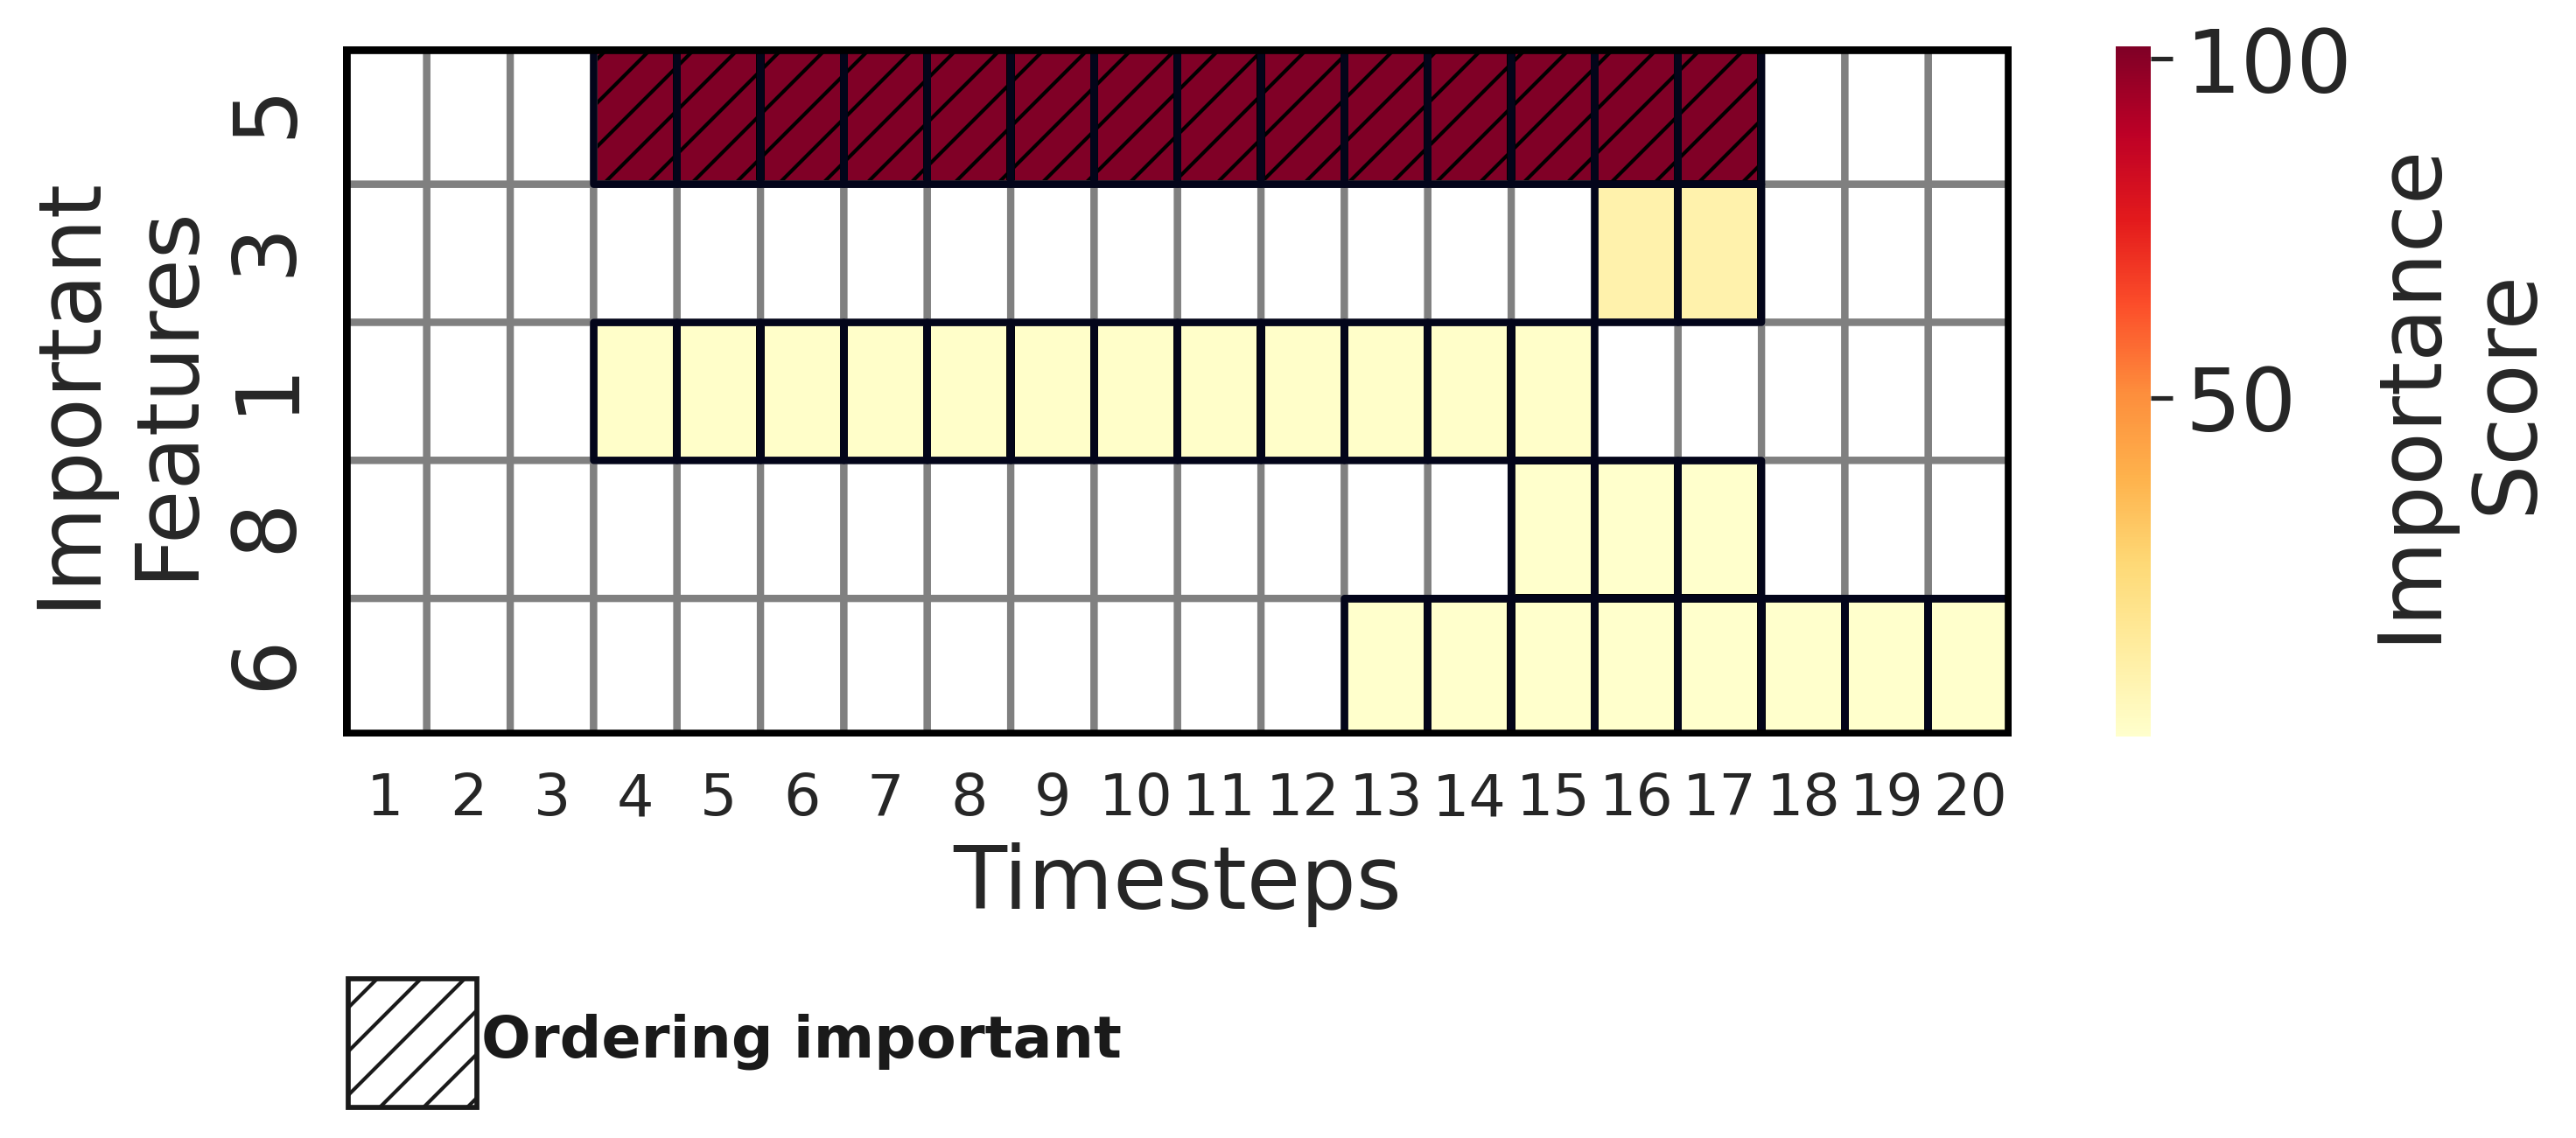

In [37]:
# Generate synthetic data and model
import synmod
output_dir = "example_synthetic_temporal"
num_features = 10
synthesized_features, X, model = synmod.synthesize(output_dir=output_dir, num_instances=100, seed=100,
                                                    num_features=num_features, fraction_relevant_features=0.5,
                                                    synthesis_type="temporal", sequence_length=20, model_type="regressor")
y = model.predict(X, labels=True)

# Analyze the model
from anamod import TemporalModelAnalyzer
analyzer = TemporalModelAnalyzer(model, X, y, output_dir=output_dir)
features = analyzer.analyze()




Summary of important features: example_synthetic_temporal/feature_importance.csv
Feature importance visualization: example_synthetic_temporal/feature_importance_windows.png


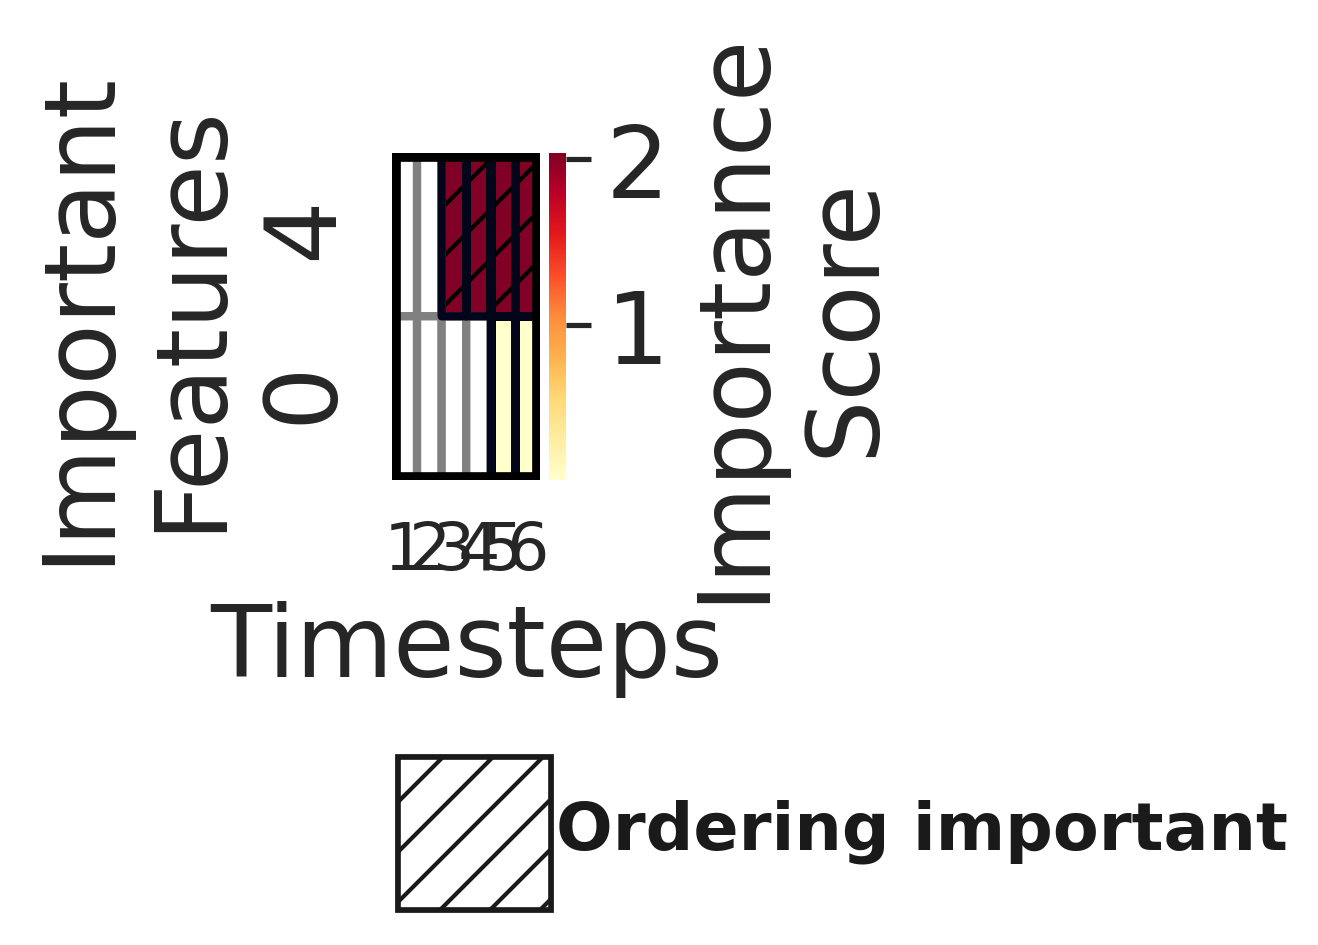

In [19]:
# Generate synthetic data and model
import synmod
output_dir = "example_synthetic_temporal"
num_features = 9
synthesized_features, X, model = synmod.synthesize(output_dir=output_dir, num_instances=600, seed=100,
                                                    num_features=num_features, fraction_relevant_features=0.5,
                                                    synthesis_type="temporal", sequence_length=6, model_type="classifier") #regressor
y = model.predict(X, labels=True)

# Analyze the model
from anamod import TemporalModelAnalyzer
analyzer = TemporalModelAnalyzer(model, X, y, output_dir=output_dir)
features = analyzer.analyze()

# Visualize feature importance for temporal windows
import subprocess


In [12]:
model

In [18]:
X.shape

(600, 9, 6)